 <font size=6> **实验10 线性神经网络**</font>

* 理解线性回归、softmax回归与线性神经网络的关系，小批量SGD使用，矢量化加速实现；
* 理解线性回归的从零开始实现中7个主要步骤的内容，理解使用PyTorch、d2l高级API简洁实现模型的主要思路和内容；
* 初识Fashion-MNIST，理解数据读取方法；
* 理解softmax回归的从零开始实现中主要步骤的内容，理解使用PyTorch、d2l高级API简洁实现模型的主要思路和内容。



# Softmax回归应用于Activity

**(实验报告提交题)** Activity_data.csv文件包含了4501行、61列的数据资料(数据集)，其中：前60列为特征、最后1列为分类结果标签(15个类，用0-14数字表示)，数据集第一行为列标题。  
	要求：请以Activity_data.csv文件为数据来源，请按7:3比例划分训练集、测试集，参考上一题softmax回归实现多分类程序(最好用简洁版本)，先用训练集数据训练模型(10轮)，再用测试集数据检验模型，输出准确率。请编程完成这一任务。

## 导入库

In [51]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from d2l import torch as d2l
from d2l_ex import train_ch3
from sklearn.model_selection import train_test_split

## 数据处理

In [52]:
data = pd.read_csv('Activity_data.csv')
data.head()

,acc_x,acc_y,acc_z,acc,acc1_x,acc1_y,acc1_z,acc2_x,acc2_y,acc2_z,acc_x_std,acc_y_std,acc_z_std,acc_std,acc1_x_std,acc1_y_std,acc1_z_std,acc2_x_std,acc2_y_std,acc2_z_std,acc_max,acc_min,acc_z_max,acc_z_min,acc_fft_sum,acc_fft_0,acc_fft_1,acc_fft_2,acc_fft_3,acc_fft_4,acc_fft_5,acc_fft_6,acc_fft_7,acc_fft_8,acc_fft_9,acc_fft_10,acc_fft_11,acc_fft_12,acc_fft_13,acc_fft_14,acc_fft_15,acc_fft_16,acc_z_fft_sum,acc_z_fft_0,acc_z_fft_1,acc_z_fft_2,acc_z_fft_3,acc_z_fft_4,acc_z_fft_5,acc_z_fft_6,acc_z_fft_7,acc_z_fft_8,acc_z_fft_9,acc_z_fft_10,acc_z_fft_11,acc_z_fft_12,acc_z_fft_13,acc_z_fft_14,acc_z_fft_15,acc_z_fft_16,label
0,3.433078,-0.872633,-0.476234,6.071189,11.443386,-4.944924,-1.706916,0.527249,-0.618134,12.687891,5.034960,2.640443,1.917046,3.451491,5.080491,3.439401,1.805220,3.609197,2.215045,4.440376,15.125138,0.529828,3.6906,-5.3961,21.412175,12.142379,0.584881,0.794823,0.923776,1.327675,3.140211,0.883080,2.259484,0.549112,1.084767,0.830505,0.927236,0.544636,0.276009,0.167452,0.059724,0.486528,11.324891,0.952467,0.085330,0.628121,0.475791,0.298727,1.227530,0.234872,1.575165,0.604569,1.000076,0.298939,0.221032,0.152104,0.096256,0.724963,0.042087,0.253862,0
1,4.512814,-1.524171,-0.592089,7.025222,12.003779,-6.241385,-1.459266,0.834183,-0.969755,13.716426,5.409326,2.750400,2.156260,3.885396,5.465990,3.847702,2.161512,4.448269,2.808452,4.135642,16.003470,1.070282,7.0133,-5.7769,20.855712,14.050444,0.080308,0.958716,0.772698,0.556321,3.979458,1.269703,1.991466,0.514023,0.713219,1.755911,0.503324,0.851005,0.200921,0.324308,1.121858,0.407320,14.181796,1.184178,0.524348,0.469058,0.609272,0.728078,1.792888,0.199358,1.069113,0.363391,0.256935,0.656080,0.902402,0.647598,0.616596,0.611727,0.635300,0.278606,0
2,4.290132,-1.778468,-0.428386,6.962806,12.075456,-6.041768,-1.353622,0.054450,-0.632754,13.768656,5.101813,3.074533,2.171708,3.661218,5.360468,3.885542,2.168416,4.253931,2.634414,4.206487,16.003470,1.070282,7.0133,-5.7769,19.685412,13.925611,0.160482,0.455712,0.905946,1.120287,3.709251,0.518554,2.047383,0.480611,0.692700,1.577496,0.570619,1.001262,0.487947,0.850197,0.469428,0.211824,13.052560,0.856772,0.317156,0.891215,0.645279,0.459400,1.619735,0.369303,0.757416,0.826932,0.152186,1.391037,0.791457,0.543923,0.486970,0.600132,0.375587,0.193030,0
3,4.397947,-2.232985,-0.533968,7.113512,12.121245,-6.528240,-1.502511,-0.413335,-0.754496,14.044340,5.097627,3.117014,1.463423,3.440227,5.500255,3.762049,1.524203,4.392933,1.993866,4.157932,15.807660,1.071733,1.9378,-5.3196,18.195762,14.227024,0.399302,0.644414,0.910788,0.916632,3.670416,0.470338,1.631687,1.054146,0.897883,0.877330,0.198689,1.062921,0.316036,0.651979,0.454778,0.104831,9.565819,1.067936,0.083690,0.688606,0.750933,0.546511,1.069479,0.269128,0.505511,0.395292,0.348466,0.599003,0.124037,0.279573,0.096542,0.476495,0.444507,0.110715,0
4,4.021226,-1.690798,-0.577751,6.870690,11.539603,-6.341941,-2.036119,-0.008426,-0.892515,13.418791,5.345828,3.241796,1.912712,3.860317,5.718965,3.581267,1.840540,4.199496,2.668087,4.564317,17.255742,0.856865,2.9604,-6.5371,22.552670,13.741381,0.390462,0.797043,0.814406,0.366626,4.136747,0.590886,1.440082,1.320856,0.854487,0.973152,0.222402,1.291660,0.626987,0.862178,0.806251,0.078750,16.741687,1.155502,0.132095,0.535695,0.529135,0.517274,1.302376,0.524426,0.760089,0.943262,0.625492,0.827090,0.318105,0.168664,0.684524,0.385842,0.543377,0.238309,0


In [53]:
X = data.iloc[:, :-1].values
y = data.iloc[:, -1].values

In [54]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [55]:
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.int64)
y_test = torch.tensor(y_test, dtype=torch.int64)

In [56]:
batch_size = 256

train_iter = d2l.load_array((X_train, y_train), batch_size)
test_iter = d2l.load_array((X_test, y_test), batch_size, is_train=True)

## 建模

### 初始化模型

In [57]:
net = nn.Sequential(nn.Flatten(), nn.Linear(60,15))

def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.01)

net.apply(init_weights)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=60, out_features=15, bias=True)
)

### 定义损失函数

In [58]:
loss = nn.CrossEntropyLoss()

### 定义优化算法

In [59]:
lr = 0.1

trainer = torch.optim.SGD(net.parameters(), lr=lr)

### 训练

epoch:10----train loss:0.005253878939482901; train acc:0.8608333333333333; test acc:0.5933333333333334


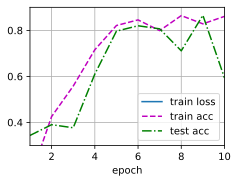

In [60]:
num_epochs = 10

train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)

### 测试集评估

In [61]:
d2l.evaluate_accuracy_gpu(net, test_iter)

0.5933333333333334

# Softmax回归引用于人脸分类

**(实验报告提交题)**我们从fetch_lfw_people数据集中选择了7位名人的脸部照片打包成pictures.zip，请先解压文件。每位名人的照片存放在一个独立的目录中，分别用A-G表示；每人有60张照片，其中48张存放在train子目录中、12张存放test子目录中，每一张照片的尺寸为 250×250像素，彩色；可参考文档，用PIL读取照片，之后可进行线性神经网络学习。  

要求：参考上一题softmax回归实现多分类程序(最好用简洁版本)，先利用train子目录照片训练模型(**50轮**)，再用测试集照片(位于test子目录中)检验模型，输出准确率。请编程完成这一任务。


参考结果：
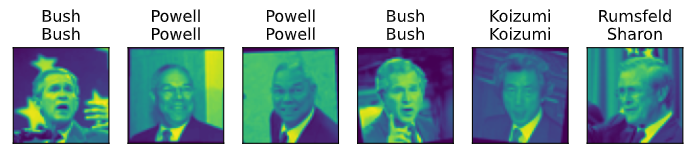

说明： 
- d2l新版本中没有train_ch3函数  
 方法1：降级安装0.17.6版  
 **方法2：import d2l_ex 调用d2l_ex.train_ch3**

## 导入库

In [62]:
import os
from PIL import Image
import matplotlib.pyplot as plt
from d2l import torch as d2l
from d2l_ex import train_ch3
import torch
from torchvision.transforms import ToTensor
from torch.utils.data import TensorDataset
from torch.utils import data
from torch import nn

## 数据处理

### 数据获取

In [63]:
train_data = []
train_labels = []
test_data = []
test_labels = []

for idx, pic_dir in enumerate(os.listdir('./pictures/')):
    train_path = os.path.join('./pictures', pic_dir, 'train')
    for filename in os.listdir(train_path):
        if filename.endswith('.jpg'):
            img = Image.open(os.path.join(train_path, filename)).convert('L')
            img = img.resize((50, 50))  # 调整大小为 50x50
            img = ToTensor()(img)  # 转换为张量
            train_data.append(img)
            train_labels.append(idx)

    test_path = os.path.join('./pictures', pic_dir, 'test')
    for filename in os.listdir(test_path):
        if filename.endswith('.jpg'):
            img = Image.open(os.path.join(test_path, filename)).convert('L')
            img = img.resize((50, 50))  # 调整大小为 50x50
            img = ToTensor()(img)  # 转换为张量
            test_data.append(img)
            test_labels.append(idx)

# 创建 TensorDataset，所有图像都为大小 50x50
lfw_train = TensorDataset(torch.stack(train_data), torch.tensor(train_labels))
lfw_test = TensorDataset(torch.stack(test_data), torch.tensor(test_labels))

### 数据查看

In [64]:
lfw_train[0][0].shape

torch.Size([1, 50, 50])

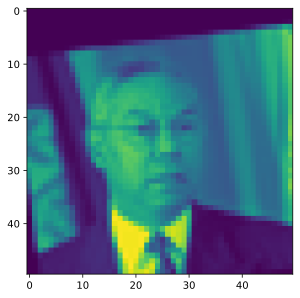

In [65]:
plt.imshow(lfw_train[48][0][0])

## 建模

### 初始化模型参数

In [66]:
net = nn.Sequential(nn.Flatten(), nn.Linear(50 * 50, 7))

def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.01)

net.apply(init_weights)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=2500, out_features=7, bias=True)
)

### 定义损失函数

In [67]:
loss = nn.CrossEntropyLoss()

### 定义优化算法


In [68]:
lr = 0.1
trainer = torch.optim.SGD(net.parameters(), lr=lr)

### 训练

epoch:50----train loss:0.0018148809183566343; train acc:1.0; test acc:0.7380952380952381


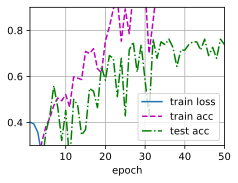

In [69]:
batch_size = 32
num_epochs = 50

train_iter = data.DataLoader(lfw_train, batch_size, shuffle=True)
test_iter = data.DataLoader(lfw_test, batch_size, shuffle=True)

train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)

### 预测

In [ ]:
for idx, pic_dir in enumerate(os.listdir('./pictures/')):
    test_path = os.path.join('./pictures', pic_dir, 'test')
    for filename in os.listdir(train_path):
        print(filename)

In [71]:
def get_lfw_labels(labels):
    text_labels = ['Sharon', 'Pwell', 'Bush', 'Rumsfeld', 'Blair', 'Chavez', 'Koizumi']
    return [text_labels[int(i)] for i in labels]

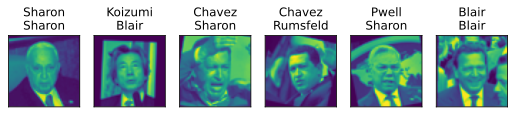

In [72]:
def predict(net, test_iter, n=6):
    for X, y in test_iter:
        break
    trues = get_lfw_labels(y)
    preds = get_lfw_labels(net(X).argmax(axis=1))
    titles = [true + '\n' + pred for true, pred in zip(trues, preds)]
    d2l.show_images(X[0:n].reshape((n, 50, 50)), 1, n, titles=titles[0:n])

predict(net, test_iter)